In [23]:
# 표준 라이브러리
import os
import random

# 데이터 처리 및 분석 라이브러리
import numpy as np
import pandas as pd
import duckdb

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt


# 진행상황 표시 라이브러리
from tqdm import tqdm

# 머신러닝 관련 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#모델
import lightgbm as lgbm
import xgboost as xgb

# data load

In [2]:
train = duckdb.query("""
    SELECT * 
    FROM '../data/train.csv'
""").to_df()

test = duckdb.query("""
    SELECT *
    FROM '../data/test.csv'
""").to_df()

train = train.drop(columns='ID')  
test = test.drop(columns='ID')
target = train['target']

print(train.shape)
print(test.shape)

(21693, 53)
(15004, 52)


# EDA

In [ ]:
# trian 확인
cols = [f'X_{str(i).zfill(2)}' for i in range(1, 53)]
num_cols = 4  # 한 행에 몇 개의 그래프를 그릴지
num_rows = (len(cols) + num_cols - 1) // num_cols  # 필요한 행 수 계산

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*3))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(data=train, y=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# 남는 subplot 영역은 삭제 또는 가리기
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
# 상관관계 heatmap 그리기
def plot_correlation_heatmap(df):
    # 상관관계 매트릭스 계산
    corr = df.corr()
    
    # 그래프 크기 설정
    plt.figure(figsize=(25, 25))
    
    # Heatmap 생성
    sns.heatmap(corr, 
        annot_kws={"size": 8},       # 네모 안의 글자 크기
                annot=True,          # 수치 표시
                fmt='.2f',           # 소수점 2자리까지 표시
                cmap='coolwarm',     # 색상 맵 (빨강-파랑)
                cbar=True,           # 컬러바 표시
                square=True,         # 정사각형 모양
                linewidths=0.1,      # 격자 선 굵기
                center=0)            # 0을 중심으로 색상 설정
    
    plt.title('Correlation Heatmap of train_x', fontsize=16)
    plt.tight_layout()
    plt.show()
plot_correlation_heatmap(train)


In [4]:
def high_corr_pairs(df, target_col=None, threshold=0.8, abs_val=True, top_k=None):

    # 숫자 컬럼만
    X = df.select_dtypes(include=[np.number]).copy()
    if target_col and target_col in X.columns:
        X = X.drop(columns=target_col)

    corr = X.corr()
    # 상삼각행렬만 사용해 중복/자기쌍 제거
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    corr_pairs = corr.where(mask).stack()  # MultiIndex (col1, col2)

    s = corr_pairs.abs() if abs_val else corr_pairs
    s = s[s >= threshold].sort_values(ascending=False)

    if top_k:
        s = s.head(top_k)

    out = pd.DataFrame({
        'feature_1': [a for a, _ in s.index],
        'feature_2': [b for _, b in s.index],
        'corr': corr_pairs.loc[s.index].values,
        'abs_corr': s.values if abs_val else corr_pairs.loc[s.index].abs().values
    })
    return out

# 사용 예시
pairs = high_corr_pairs(train)
pairs

,feature_1,feature_2,corr,abs_corr
0,X_06,X_45,1.000000,1.000000
1,X_10,X_17,1.000000,1.000000
2,X_26,X_30,0.998476,0.998476
3,X_05,X_25,0.998199,0.998199
4,X_38,X_47,0.997542,0.997542
5,X_07,X_33,0.993494,0.993494
6,X_20,X_22,0.992518,0.992518
7,X_04,X_39,0.990993,0.990993
8,X_09,X_20,0.987664,0.987664
9,X_05,X_51,0.984997,0.984997


In [5]:
# pairs의 각 행에 대해 feature_1, feature_2 중 타깃과 상관이 더 높은 것 찾기
def find_higher_corr_feature(pairs, df, target_col='target'):
    """
    pairs의 각 쌍에서 target과 상관이 더 높은 변수를 찾아서 새 컬럼으로 추가
    """
    result = pairs.copy()
    
    # 각 쌍에 대해 반복
    higher_corr_features = []
    for idx, row in pairs.iterrows():
        f1, f2 = row['feature_1'], row['feature_2']
        
        # 각 변수와 타깃의 상관계수 계산
        corr1 = df[f1].corr(df[target_col])
        corr2 = df[f2].corr(df[target_col])
        
        # 절대값으로 비교해서 더 높은 것 선택
        if abs(corr1) > abs(corr2):
            higher_corr_features.append(f1)
        else:
            higher_corr_features.append(f2)
    
    result['higher_corr_feature'] = higher_corr_features
    
    # 중복 제거된 리스트
    unique_higher_features = list(set(higher_corr_features))
    
    return result, unique_higher_features

# 사용
result, unique_features = find_higher_corr_feature(pairs, train, 'target')
print("중복 없는 higher_corr_features:", unique_features)
print(f"총 {len(unique_features)}개")

중복 없는 higher_corr_features: ['X_35', 'X_18', 'X_09', 'X_17', 'X_39', 'X_45', 'X_28', 'X_43', 'X_38', 'X_31', 'X_30', 'X_52', 'X_14', 'X_21', 'X_05', 'X_20', 'X_04', 'X_26', 'X_47', 'X_33', 'X_51', 'X_16', 'X_22']
총 23개


# 피처 엔지니어링

In [6]:
X_train = train.drop(columns='target')
X_test = test
y_train = train['target']

# 전처리 (정규화, 왜도 등)

In [7]:

# pairs: 상관관계 높은 피처 쌍 데이터프레임
# columns=['feature_1', 'feature_2', 'corr', 'abs_corr']

# X_train, X_test: 원본 데이터프레임

# 1. 교호작용 변수 추가
for idx, row in pairs.iterrows():
    f1, f2 = row['feature_1'], row['feature_2']
    new_col = f"{f1}_x_{f2}"
    X_train[new_col] = X_train[f1] * X_train[f2]
    X_test[new_col]  = X_test[f1] * X_test[f2]

# # 2. 교호작용에 들어간 변수들 모두 set에 모으기
features_to_remove = set(pairs['feature_1']).union(set(pairs['feature_2']))

# # 3. 원본 변수 삭제
# X_train = X_train.drop(columns=list(features_to_remove))
# X_test  = X_test.drop(columns=list(features_to_remove))

# 결과 확인
# print("추가된 교호작용 변수 개수:", len(pairs))
# print("삭제된 원본 변수 개수:", len(features_to_remove))
print("최종 X_train shape:", X_train.shape)
print("최종 X_test shape:", X_test.shape)

최종 X_train shape: (21693, 106)
최종 X_test shape: (15004, 106)


In [8]:
# 왜도, 첨도 완화
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=False)
X_train  = pt.fit_transform(X_train)
X_test = pt.transform(X_test)


In [9]:
from sklearn.preprocessing import QuantileTransformer

norm = QuantileTransformer()
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

# 모델링

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

# 2. 5-Fold 교차검증
n_class = 21  # 클래스 개수에 맞게 수정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_macro_f1 = []
oof_pred = np.zeros((len(X_train), n_class), dtype=float)
oof_label = np.zeros(len(X_train), dtype=int)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_tr, X_va = X_train[tr_idx], X_train[va_idx]
    y_tr, y_va = y_train[tr_idx], y_train[va_idx]
    
    # 모델 파라미터
    model_xgb = XGBClassifier(
        objective='multi:softprob',
        num_class=n_class,
        # n_estimators=3000,
        # learning_rate=0.02,
        max_depth=6,
        subsample=0.8,
        colsample_bytree = 0.8,
        tree_method='hist',
        eval_metric='auc',
        random_state=42,
        early_stopping_rounds=50,
        n_jobs=-1)

    # 모델에게 학습데이터 학습시키기
    model_xgb.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        verbose=False,
    )
    
    y_pred = model_xgb.predict(X_va)
    macro_f1 = f1_score(y_va, y_pred, average='macro')
    fold_macro_f1.append(macro_f1)
    oof_label[va_idx] = y_pred
    oof_pred[va_idx] = model_xgb.predict_proba(X_va)
    
    print(f'Fold {fold} Macro F1: {macro_f1:.4f}')

overall_macro_f1 = f1_score(y_train, oof_label, average='macro')
print(f'\n10-Fold OOF Macro F1 (XGB, Normalized): {overall_macro_f1:.4f}')
print(f'Fold별 Macro F1 평균: {np.mean(fold_macro_f1):.4f}, 표준편차: {np.std(fold_macro_f1):.4f}')


Fold 1 Macro F1: 0.7900
Fold 2 Macro F1: 0.7883
Fold 3 Macro F1: 0.7883
Fold 4 Macro F1: 0.7933
Fold 5 Macro F1: 0.7947

10-Fold OOF Macro F1 (XGB, Normalized): 0.7910
Fold별 Macro F1 평균: 0.7909, 표준편차: 0.0026


Fold 1 Macro F1: 0.8056


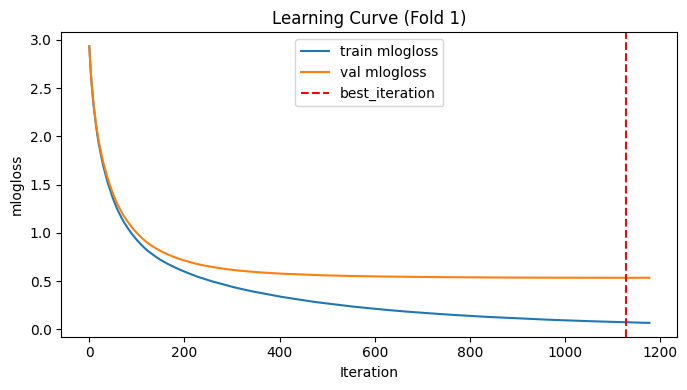

Fold 2 Macro F1: 0.8021


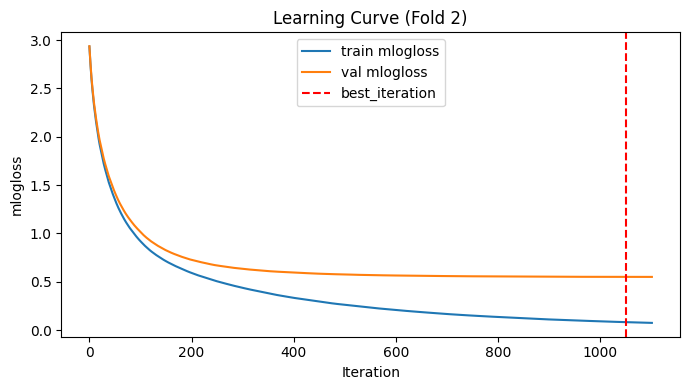

Fold 3 Macro F1: 0.7999


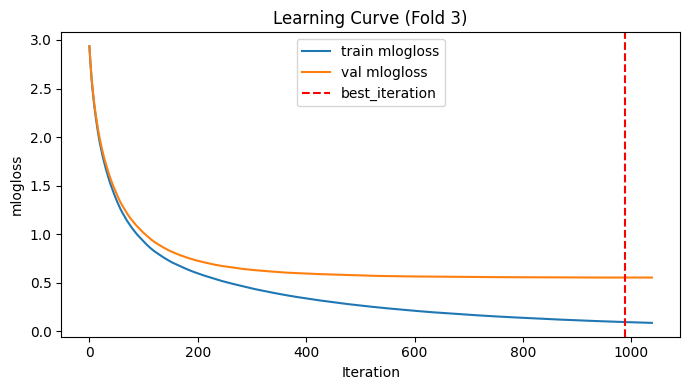

Fold 4 Macro F1: 0.8057


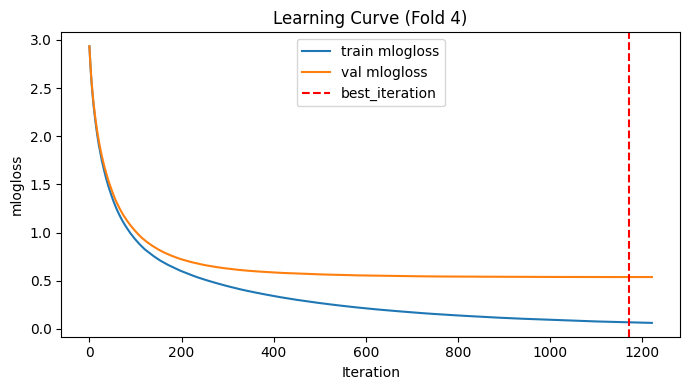

Fold 5 Macro F1: 0.7997


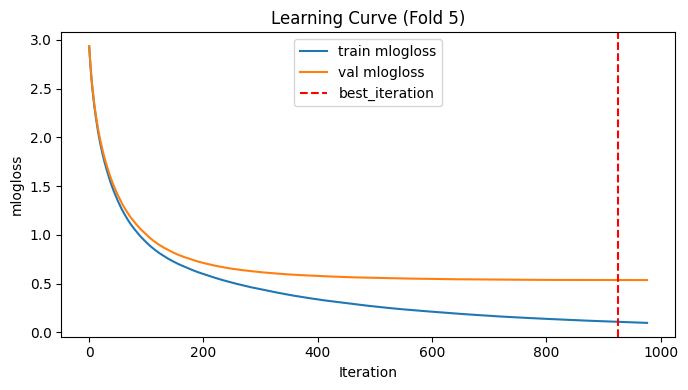


5-Fold OOF Macro F1 (XGB, Normalized): 0.8026
Fold별 Macro F1 평균: 0.8026, 표준편차: 0.0026


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

# 2. 5-Fold 교차검증
n_class = 21
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_macro_f1 = []
oof_pred = np.zeros((len(X_train), n_class), dtype=float)
oof_label = np.zeros(len(X_train), dtype=int)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_tr, X_va = X_train[tr_idx], X_train[va_idx]
    y_tr, y_va = y_train[tr_idx], y_train[va_idx]
    
    model_xgb = XGBClassifier(
        objective='multi:softprob',
        num_class=n_class,
        n_estimators=3000,
        learning_rate=0.02,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',          # 또는 'merror'
        early_stopping_rounds=50,        # fit에 넣기
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    )

    # 학습: train/val 모두 eval_set에 넣고, 다중분류에 맞는 metric 사용
    model_xgb.fit(
        X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_va, y_va)],
        verbose=False
    )
    
    # 예측 및 점수
    y_pred = model_xgb.predict(X_va)
    macro_f1 = f1_score(y_va, y_pred, average='macro')
    fold_macro_f1.append(macro_f1)
    oof_label[va_idx] = y_pred
    oof_pred[va_idx] = model_xgb.predict_proba(X_va)
    print(f'Fold {fold} Macro F1: {macro_f1:.4f}')

    # 학습곡선 출력
    evals_result = model_xgb.evals_result()
    # validation_0: train, validation_1: val
    train_metric = evals_result['validation_0']['mlogloss']
    val_metric   = evals_result['validation_1']['mlogloss']

    plt.figure(figsize=(7, 4))
    plt.plot(train_metric, label='train mlogloss')
    plt.plot(val_metric, label='val mlogloss')
    # best_iteration는 0-based. 시각적으로 표시
    if hasattr(model_xgb, 'best_iteration') and model_xgb.best_iteration is not None:
        plt.axvline(model_xgb.best_iteration, color='r', linestyle='--', label='best_iteration')
    plt.title(f'Learning Curve (Fold {fold})')
    plt.xlabel('Iteration')
    plt.ylabel('mlogloss')
    plt.legend()
    plt.tight_layout()
    plt.show()

overall_macro_f1 = f1_score(y_train, oof_label, average='macro')
print(f'\n5-Fold OOF Macro F1 (XGB, Normalized): {overall_macro_f1:.4f}')
print(f'Fold별 Macro F1 평균: {np.mean(fold_macro_f1):.4f}, 표준편차: {np.std(fold_macro_f1):.4f}')


In [28]:
from sklearn.metrics import classification_report

# 예측값과 실제값 준비
# y_true = 실제 정답 (예: y_test)
# y_pred = 모델 예측값

print(classification_report(y_va, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.1875    0.2039    0.1953       206
           1     1.0000    1.0000    1.0000       206
           2     1.0000    1.0000    1.0000       206
           3     0.5045    0.5388    0.5211       206
           4     0.9717    0.9952    0.9833       207
           5     1.0000    1.0000    1.0000       206
           6     1.0000    1.0000    1.0000       206
           7     1.0000    1.0000    1.0000       206
           8     0.9799    0.9466    0.9630       206
           9     0.1681    0.1932    0.1798       207
          10     0.7848    0.8454    0.8140       207
          11     0.9574    0.8696    0.9114       207
          12     0.9343    0.9660    0.9499       206
          13     0.9851    0.9565    0.9706       207
          14     0.8291    0.7971    0.8128       207
          15     0.2130    0.2222    0.2175       207
          16     0.7719    0.6377    0.6984       207
          17     1.0000    

# 전체 데이터 학습

In [ ]:
# validation 결과가 가장 좋은 모델 채택
model_xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=21,
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=1.0,
    colsample_bytree =1.0,
    tree_method='hist',   # M1/M2에서도 빠름
    random_state=42,
    n_jobs=-1
)

# 모델 학습
model_xgb.fit(X_train, y_train)

# 예측 및 평가
preds = model_xgb.predict(X_test)          # 학습된 모델로 test_x 데이터에 대해 예측 수행

# Submission


In [12]:
submission = pd.read_csv('../data/sample_submission.csv')
submission['target'] = preds
submission
submission.to_csv('./submit.csv', index=False, encoding='utf-8-sig')